# Arrenda in Sardìnnia in su 2019

In [10]:
import pandas as pd

economic_data = pd.read_csv("arrenda-imponìbili.csv")
economic_data = economic_data.dropna()

In [11]:
import geopandas as gp

map_data = gp.read_file('/sustainablesardinia/air-quality/preliminary_investigation/data/geo/comune-limits.shp')

def _normalize_accents(text):
    import unicodedata
    try:
        text = unicode(text, 'utf-8')
    except NameError:
        pass
    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("utf-8")
    return text

def _remove_apostrophes(text):
    return text.replace("'", "")

map_data['nome'] = map_data['nome'].apply(_normalize_accents).apply(_remove_apostrophes)

economic_data['Comune'] = economic_data['Comune'].astype('str')
economic_data['comune_simplified'] = economic_data['Comune'].apply(_normalize_accents).apply(_remove_apostrophes).apply(lambda n : n.upper())
merged_map = map_data.merge(economic_data,
                            how="inner",
                            left_on="nome",
                            right_on="comune_simplified")
merged_map.head()

,idFeature,nome,codIstatCo,codIstatPr,codIstatRe,codComune,geometry,Codice Istat,Comune,Ripartizione sovracomunale,Posizione Graduatoria,Ammontare (A),Frequenza (B),Media (A/B),Indice (Media Sardegna=1),comune_simplified
0,58,POSADA,091073,091,20,G929,"POLYGON ((1563346.750 4496755.000, 1563372.125...",91073,Posada,Nuoro,111.0,"31,634","2,024",15.63,0.87,POSADA
1,133,SARULE,091077,091,20,I448,"POLYGON ((1517201.125 4449946.500, 1517204.750...",91077,Sarule,Nuoro,318.0,"13,562","1,035",13.10,0.73,SARULE
2,117,SILANUS,091083,091,20,I730,"POLYGON ((1496362.125 4457635.000, 1496357.125...",91083,Silanus,Nuoro,161.0,"18,735","1,250",14.99,0.84,SILANUS
3,119,SINDIA,091084,091,20,I748,"POLYGON ((1468251.625 4457125.500, 1468265.375...",91084,Sindia,Nuoro,236.0,"15,314","1,092",14.02,0.78,SINDIA
4,197,SINISCOLA,091085,091,20,I751,"MULTIPOLYGON (((1569930.875 4485678.500, 15699...",91085,Siniscola,Nuoro,175.0,"105,815","7,157",14.78,0.83,SINISCOLA


In [12]:
toponims_data = gp.read_file('Topònimus/TOP_macroToponimi.shp')
toponims_data = toponims_data.loc[:, ['topoItalia', 'topoSardo', 'codIstCom']]
toponims_data.head()

,topoItalia,topoSardo,codIstCom
0,Olbia,TERRANOA/TARRANOA,104017
1,Sassari,SÀSSARI/TÀTARI,090064
2,Tortolì,TORTOLÌ,105018
3,Lanusei,LANUSÈ,105010
4,Sanluri,SEDDORI,106015


In [13]:
print(list(set(map_data['nome'])-set(economic_data['comune_simplified'])))

[]


In [14]:
import numpy as np
from numba import jit

def _get_centroids_of_geometries(total_data):
    ''' Given the total_data dataframe, compute the middle points of every geometry
        associated with a comune 
    '''
    total_data['coordinates'] = total_data['geometry'].apply(lambda x: x.representative_point().coords[:])
    total_data['coordinates'] = [coords[0] for coords in total_data['coordinates']]

    x_value = [coords[0] for coords in total_data['coordinates']]    
    y_value = [coords[1] for coords in total_data['coordinates']]
    name = total_data['nome']
    
    coords_and_names = pd.DataFrame(zip(name, x_value, y_value), columns=['name', 'x_value', 'y_value'])
    coords_and_names = coords_and_names.sort_values(by='y_value', ascending=0).reset_index(drop=True)

    return coords_and_names

centroids = _get_centroids_of_geometries(merged_map)
number_of_points = centroids.shape[0]
cx = centroids['x_value'].to_numpy(dtype ='float64')
cy = centroids['y_value'].to_numpy(dtype ='float64')

nc = len(cx)
print("Min distance on the x axis: ", np.absolute(cx[0:nc-1]-cx[1:nc]).min())
print("Min distance on the y axis: ", np.absolute(cy[0:nc-1]-cy[1:nc]).min())

label_font_size = 7

c = np.concatenate([cx, cy])
characters = merged_map['nome'].apply(len).to_numpy(dtype ='float64')
width_per_character = label_font_size * 800/4.0
height_per_character = label_font_size * 1200.0/4.0

w = characters * width_per_character / 2.0
h = 1 * height_per_character
Dx = 2 * width_per_character
Dy = 3 * height_per_character
lb = np.concatenate([cx-Dx, cy-Dy])
ub = np.concatenate([cx+Dx, cy+Dy])

def distance_from_centroid(variables):
    x = variables[0:number_of_points]
    y = variables[number_of_points:]
    return (np.power(x-cx, 2) + np.power(y-cy, 2)).sum()

@jit(nopython=True)
def overlap_between_points_extended(variables):
    number_of_constraints = int(number_of_points * (number_of_points - 1) / 2)

    x = variables[0:number_of_points]
    y = variables[number_of_points:]
    o = np.zeros((number_of_constraints, 1))
    d = np.zeros((number_of_points, 1))
    
    k = 0
    for i in range(0, number_of_points):
        d[i] = np.power(y[i]-cy[i], 2) + np.power(x[i]-cx[i], 2) 

        for j in range(i+1, number_of_points):
            dist_y = np.absolute(y[i] - y[j]) - 2*h
            dist_x = np.absolute(x[i] - x[j]) - (w[i] + w[j])
            o[k] = 0 if dist_y > 0 or dist_x > 0 else dist_y * dist_x
            k += 1
    return o.sum() + 0.1*d.sum()

Min distance on the x axis:  1328.922022565268
Min distance on the y axis:  0.25


In [15]:
import scipy.optimize

bounds = scipy.optimize.Bounds(lb, ub)

# label_positions = scipy.optimize.basinhopping(overlap_between_points_extended,
#     c,
#     stepsize=3*h,
#     niter=150,
#     minimizer_kwargs={'method': 'Powell', 'bounds': bounds},
#     disp=True)

# bounds_list = list(zip(lb, ub))
# 
# label_positions = scipy.optimize.dual_annealing(overlap_between_points_extended,
#     bounds_list,
#     x0=c)

In [16]:
import math

num_classes = 4
data = merged_map["Media (A/B)"]
min_scale = math.floor(min(data))
max_scale = math.ceil(max(data))
step = round((max_scale-min_scale)/num_classes)
classes = ([v for v in range(max_scale, min_scale, -step)] + [min_scale])
classes.sort()

print(classes)

x = [12, 21, 22]

def _interval_number(v):
    for index in range(0, len(classes)-1):
        if v >= classes[index] and v<classes[index+1]:
            return index
    return None

y = list(map(_interval_number, x))
print(y)

def _interval_label(i):
    return f"De {classes[i]} a {classes[i+1]}"

scale_labels = [_interval_label(i) for i in range(0, num_classes)]
print(scale_labels)

merged_map['Categories'] = merged_map["Media (A/B)"].apply(_interval_number)

[10, 14, 18, 22, 26]
[0, 2, 3]
['De 10 a 14', 'De 14 a 18', 'De 18 a 22', 'De 22 a 26']


In [17]:
# centroids['label_x'] = label_positions.x[0:number_of_points]
# centroids['label_y'] = label_positions.x[number_of_points:]
# centroids['width'] = w
# 
# centroids['y_displacement'] = centroids.apply(lambda r: np.absolute(r['label_y']-r['y_value']), axis=1)
# print("Max Y displacement: ", centroids['y_displacement'].max())
# 
# centroids['x_displacement'] = centroids.apply(lambda r: np.absolute(r['label_x']-r['x_value']), axis=1)
# print("Max X displacement: ", centroids['x_displacement'].max())
# 
# print(centroids.loc[centroids.name=='SETZU'])

print(merged_map.loc[merged_map['Ripartizione sovracomunale'] == 'Oristano'].nome.to_list())

['SENIS', 'SENNARIOLO', 'SIAMAGGIORE', 'SIAMANNA', 'SIMALA', 'SIMAXIS', 'SINI', 'LACONI', 'MAGOMADAS', 'MODOLO', 'MONTRESTA', 'SAGAMA', 'SUNI', 'TINNURA', 'BUSACHI', 'CABRAS', 'CUGLIERI', 'FORDONGIANUS', 'GHILARZA', 'GONNOSCODINA', 'GONNOSNO', 'GONNOSTRAMATZA', 'MARRUBIU', 'MASULLAS', 'MILIS', 'MOGORELLA', 'MOGORO', 'MORGONGIORI', 'NARBOLIA', 'NEONELI', 'NORBELLO', 'NUGHEDU SANTA VITTORIA', 'NURACHI', 'NURECI', 'OLLASTRA', 'ORISTANO', 'PALMAS ARBOREA', 'PAU', 'PAULILATINO', 'POMPU', 'RIOLA SARDO', 'RUINAS', 'SAMUGHEO', 'SAN NICOLO DARCIDANO', 'SANTA GIUSTA', 'VILLA SANTANTONIO', 'SANTU LUSSURGIU', 'SAN VERO MILIS', 'SCANO DI MONTIFERRO', 'SEDILO', 'SENEGHE', 'ZEDDIANI', 'ZERFALIU', 'SIAPICCIA', 'CURCURIS', 'SODDI', 'ASSOLO', 'ASUNI', 'BARADILI', 'BOSA', 'FLUSSIO', 'SIRIS', 'SOLARUSSA', 'SORRADILE', 'TADASUNI', 'TERRALBA', 'TRAMATZA', 'TRESNURAGHES', 'ULA TIRSO', 'URAS', 'USELLUS', 'VILLANOVA TRUSCHEDU', 'VILLAURBANA', 'VILLA VERDE', 'BARATILI SAN PIETRO', 'BARESSA', 'BAULADU', 'BIDONI'

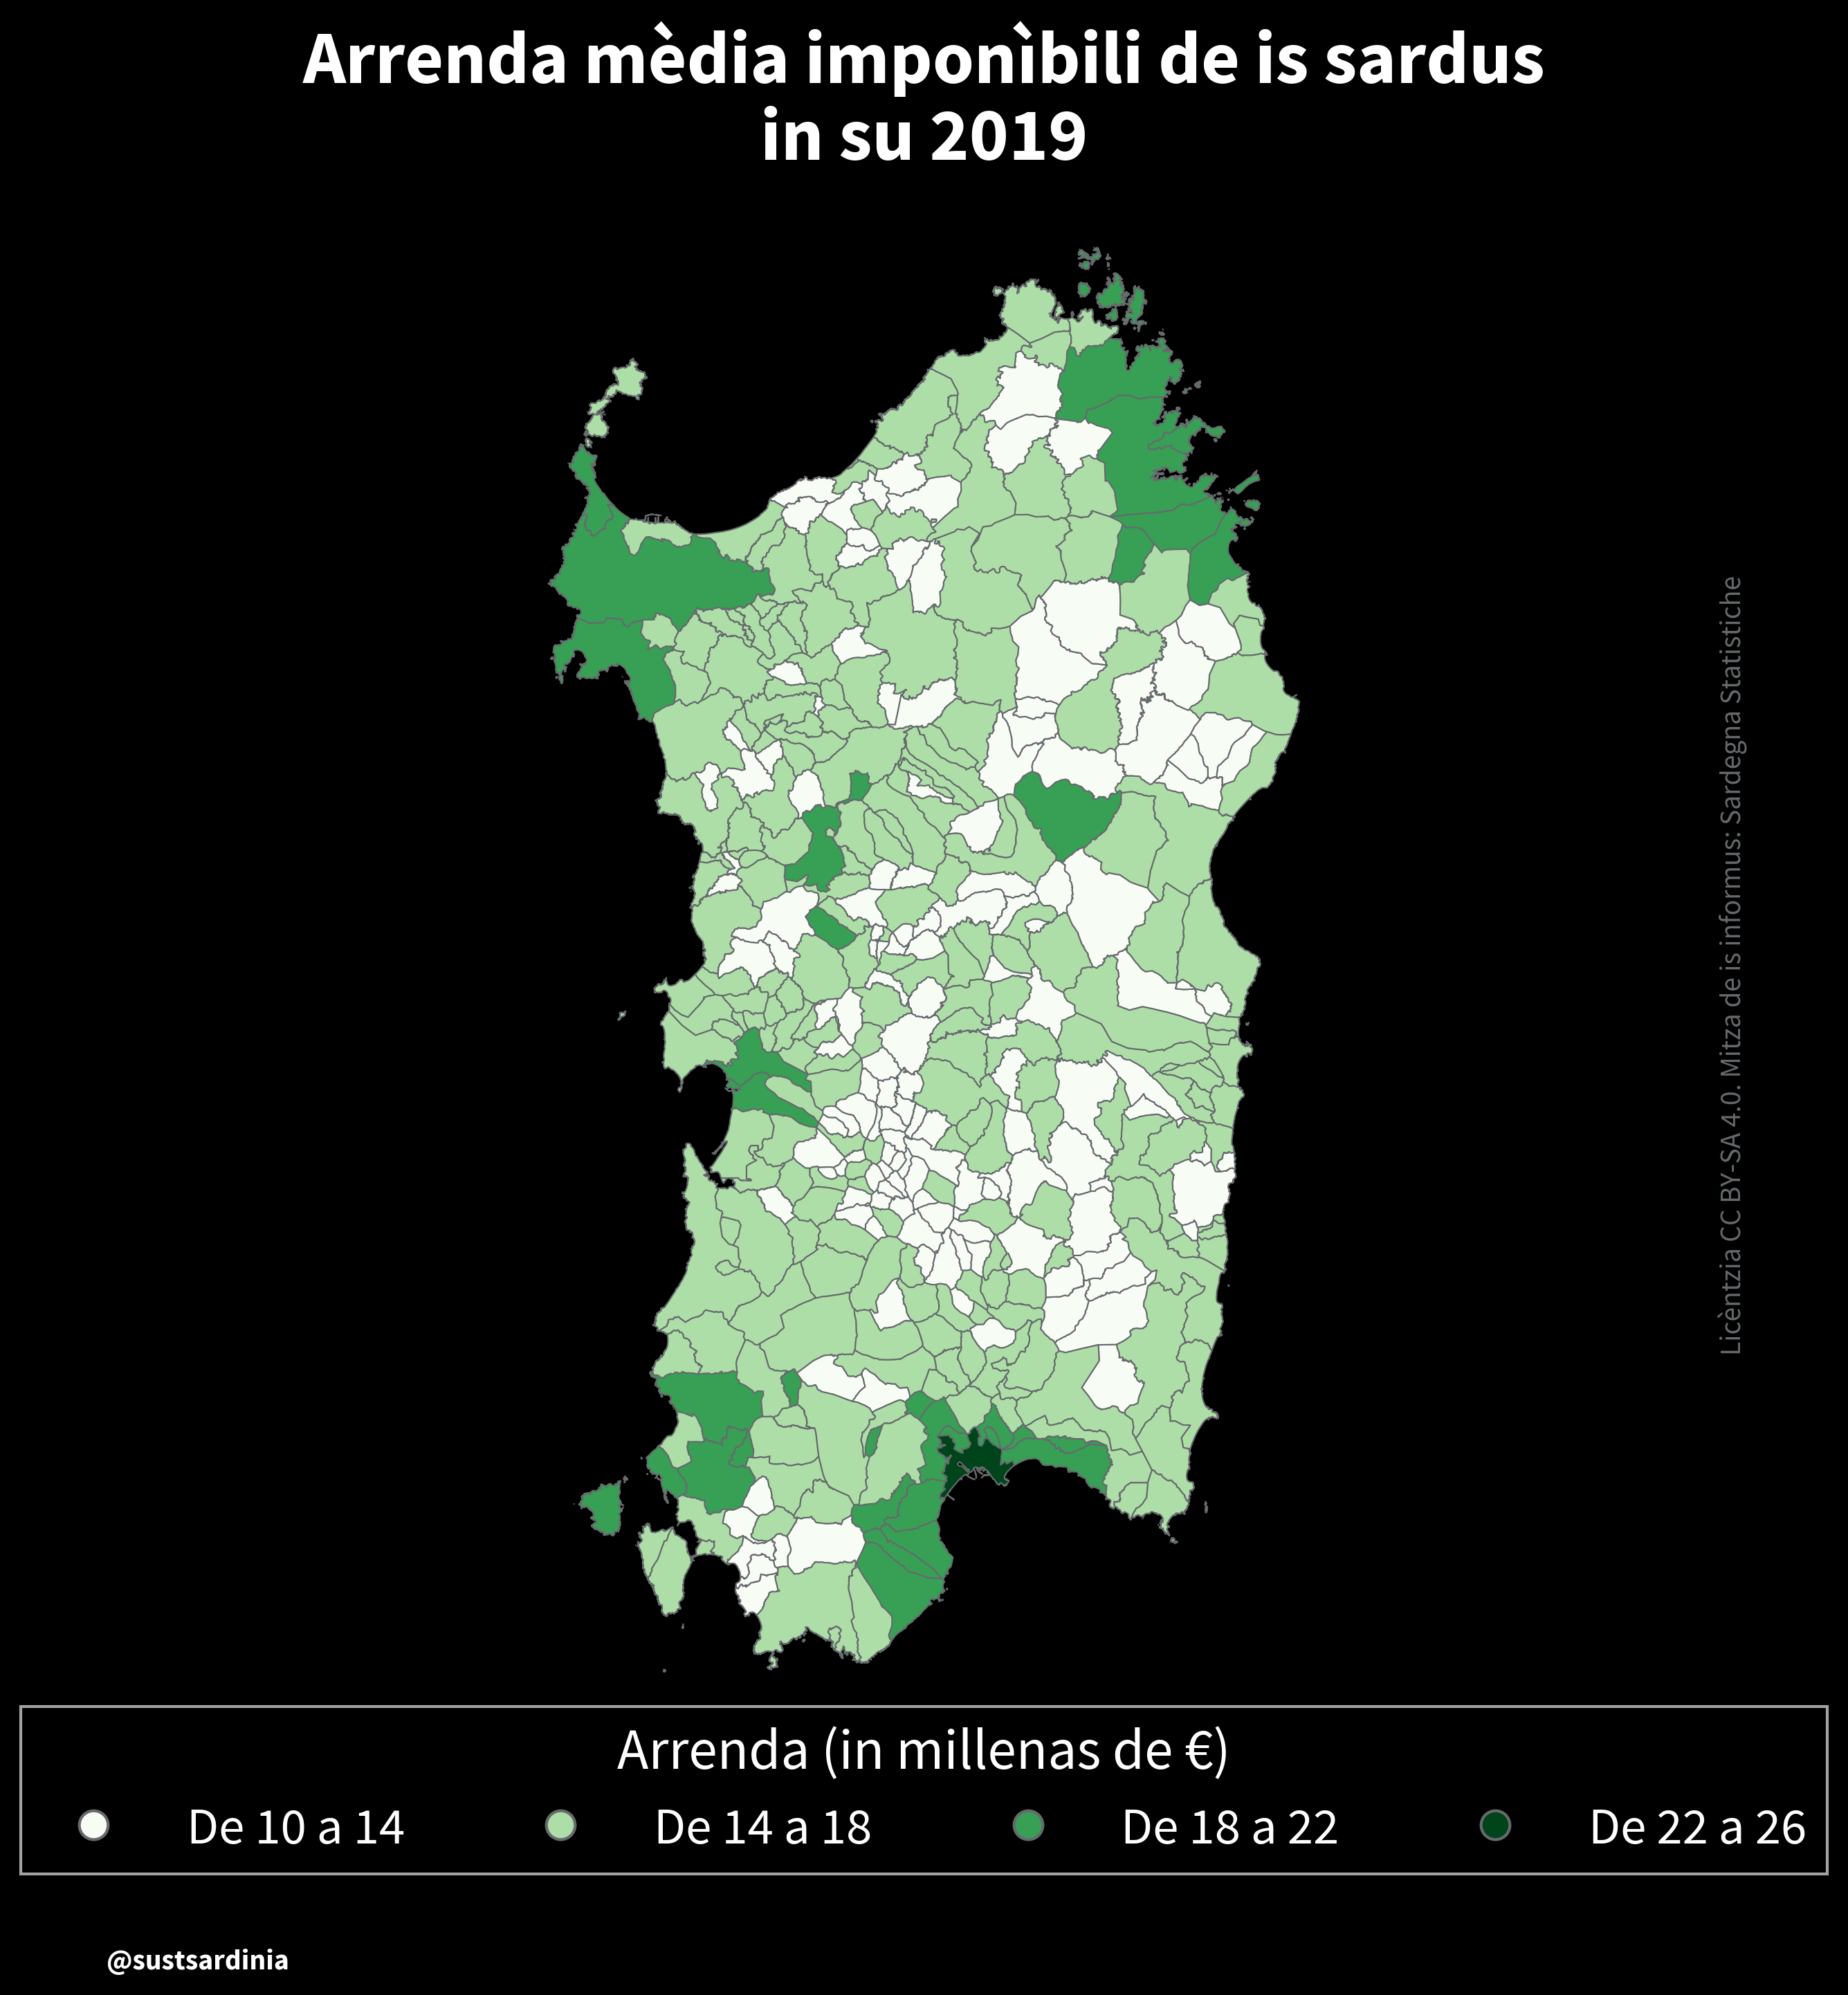

In [25]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib
import matplotlib.patches

def _plot_comune_labels(centroids, font_size=3):
    for _, row in centroids.iterrows():
        annotation = plt.annotate(text=row['name'].upper(),        
            xy=(row['x_value'],row['y_value']), 
            horizontalalignment='center', 
            color='black', 
            size=font_size)
        annotation.set_path_effects([path_effects.withStroke(linewidth=1, foreground='w')])

def _plot_data(df, centroids):
    
    edge_color = '#666A6D'
    foreground_color = 'white'

    matplotlib.rcParams['font.family'] = 'sans-serif'
    matplotlib.rcParams['font.sans-serif'] = 'Source Sans Pro'
    matplotlib.rcParams['text.color'] = foreground_color
    

    fig, ax = plt.subplots(figsize=(8, 10), dpi=300, facecolor='black')
    plt.tick_params(left=False,
                    bottom=False,
                    labelleft=False,
                    labelbottom=False)


    chart = df.plot(column="Categories",
                    cmap='Greens',
                    ax=ax,
                    linewidth=0.5,
                    edgecolor=edge_color,
                    legend=True,
                    k=num_classes,
                    scheme='equal_interval',
                    legend_kwds={
                        'loc': 'lower center', 
                        'fontsize': 18,
                        'bbox_to_anchor': (0.5, -0.1),
                        'title': 'Arrenda (in millenas de €)',
                        'title_fontsize': 20,
                        'labelcolor': foreground_color,
                        'labels': scale_labels,
                        'handletextpad': 0.1,
                        'ncol': 4,
                        'facecolor': 'black',
                        'fancybox': False,
                        'shadow': False,
                        'labelspacing': 0.5
                        })
    for legend_handle in ax.get_legend().legendHandles:  
        legend_handle._legmarker.set_markeredgewidth(1)
        legend_handle._legmarker.set_markeredgecolor(edge_color)
    ax.axis('off')
    _ = ax.set_title(
            'Arrenda mèdia imponìbili de is sardus\nin su 2019', fontsize=26, fontweight='bold')

    plt.figtext(0.999, 0.5, "Licèntzia CC BY-SA 4.0. Mitza de is informus: Sardegna Statistiche", rotation=90, ha="center", va="center", fontsize=10, c=edge_color)
    plt.figtext(0.02, 0.02, "@sustsardinia", ha="left", va="center", fontdict={'size': 10, 'weight': 'bold', 'color': foreground_color})    

    plt.savefig("arrenda.png", bbox_inches = "tight")
    
_plot_data(merged_map, centroids)